This is a notebook which explains how I created a network map of NXT Takeover matches. This was written in Spring 2019.

In [1]:
import numpy as np
import numpy.linalg as la
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import json
import requests
import os
import itertools
import bs4
import networkx
import urllib.request
from itertools import combinations
from bs4 import BeautifulSoup

import time
from tqdm import tqdm

Web scraping: get up-to-date list of NXT TakeOvers, get results from each Wikipedia page:

In [32]:
webpage = 'https://en.wikipedia.org/wiki/NXT_TakeOver' 
nxt_html = requests.get(webpage)
soup = BeautifulSoup(nxt_html.text, features='html.parser')

print(nxt_html)
links = []

for link in soup.find_all('a'): #starting with crummy documentation, followed by modifications to turn output into actual links
    links.append(link.get('href'))
    
links[:5]

<Response [200]>


[None,
 '#mw-head',
 '#p-search',
 '/wiki/NXT_TakeOver_(2014)',
 '/wiki/NXT_UK_TakeOver']

In [7]:
for link in links:
    if link is None:
        links.remove(link)

good_words = ['NXT', 'TakeOver', '/wiki/']
bad_words = ['https:']
NXT_links = [s for s in links if 'NXT' in s]
NXT_links = [s for s in NXT_links if 'TakeOver' in s]
NXT_links = [s for s in NXT_links if '/wiki/' in s]
NXT_links = [s for s in NXT_links if 'https:' not in s]
NXT_links = [s for s in NXT_links if 'Category' not in s]
NXT_links = [s for s in NXT_links if 'Special' not in s]
NXT_links = [s for s in NXT_links if 'Talk:' not in s]

NXT_links = set(NXT_links)
NXT_links

{'/wiki/NXT_TakeOver',
 '/wiki/NXT_TakeOver:_Boston',
 '/wiki/NXT_TakeOver:_Brooklyn',
 '/wiki/NXT_TakeOver:_Brooklyn_4',
 '/wiki/NXT_TakeOver:_Brooklyn_II',
 '/wiki/NXT_TakeOver:_Brooklyn_III',
 '/wiki/NXT_TakeOver:_Chicago',
 '/wiki/NXT_TakeOver:_Chicago_II',
 '/wiki/NXT_TakeOver:_Dallas',
 '/wiki/NXT_TakeOver:_Fatal_4-Way',
 '/wiki/NXT_TakeOver:_London',
 '/wiki/NXT_TakeOver:_New_Orleans',
 '/wiki/NXT_TakeOver:_New_York',
 '/wiki/NXT_TakeOver:_Orlando',
 '/wiki/NXT_TakeOver:_Philadelphia',
 '/wiki/NXT_TakeOver:_Phoenix',
 '/wiki/NXT_TakeOver:_R_Evolution',
 '/wiki/NXT_TakeOver:_Respect',
 '/wiki/NXT_TakeOver:_Rival',
 '/wiki/NXT_TakeOver:_San_Antonio',
 '/wiki/NXT_TakeOver:_The_End',
 '/wiki/NXT_TakeOver:_Toronto_(2016)',
 '/wiki/NXT_TakeOver:_Toronto_(2019)',
 '/wiki/NXT_TakeOver:_Unstoppable',
 '/wiki/NXT_TakeOver:_WarGames_(2017)',
 '/wiki/NXT_TakeOver:_WarGames_(2018)',
 '/wiki/NXT_TakeOver:_WarGames_(2019)',
 '/wiki/NXT_TakeOver:_XXV',
 '/wiki/NXT_TakeOver_(2014)',
 '/wiki/NXT_

In [8]:
wikipedia = 'https://en.wikipedia.org/'
results = '#Results'
webpage = 'https://en.wikipedia.org/wiki/NXT_TakeOver_(2014)#Results'
links = []

nxt_html = requests.get(webpage)

print(nxt_html)


<Response [200]>


In [9]:
import urllib.request

url = 'https://en.wikipedia.org/wiki/NXT_TakeOver:_Unstoppable'
req = urllib.request.urlopen(url)
article = req.read().decode()

with open('ISO_3166-1_alpha-2.html', 'w', encoding="utf-8") as fo:
    fo.write(article)

In [33]:
#test to make sure script is pulling results of matches

article = open('ISO_3166-1_alpha-2.html', encoding='utf-8').read()
soup = bs4.BeautifulSoup(article, 'html.parser')

td = soup.find_all('td')
td = [s for s in td if type(s) != 'NoneType']

text_version = []
for item in td:
    text_version.append(item.get_text().rstrip())
    
text_version[:5]

['The current logo for NXT UK TakeOver',
 'WWE',
 'NXT UK',
 'NXT UK TakeOver: Blackpool',
 'NXT UK TakeOver: Blackpool']

In [11]:
#only pulls results - this is fairly straightforward, as there haven't been 'no contest' or 'draw' results at NXT Takeover
#to my knowledge
text_version = [s for s in text_version if 'defeated' in s]
text_version

['The Mechanics (Dash Wilder and Scott Dawson) defeated The Vaudevillains (Aiden English and Simon Gotch)',
 'Finn Bálor defeated Tyler Breeze',
 'Bayley and Charlotte defeated Dana Brooke and Emma',
 'Baron Corbin defeated Rhyno',
 'Blake and Murphy (c) defeated Colin Cassady and Enzo Amore (with Carmella)',
 'Sasha Banks (c) defeated Becky Lynch by submission']

In [12]:
root = 'https://en.wikipedia.org/'

text_version = []

for event in NXT_links:
    event_mod = event[6:]
    event_title = event_mod.replace('_', ' ')
    url = root + event
    req = urllib.request.urlopen(url)
    article = req.read().decode()

    with open('ISO_3166-1_alpha-2.html', 'w', encoding="utf-8") as fo:
        fo.write(article)
        article = open('ISO_3166-1_alpha-2.html', encoding='utf-8').read()
    
    soup = bs4.BeautifulSoup(article, 'html.parser')

    td = soup.find_all('td')
    td = [s for s in td if type(s) != 'NoneType']

    for item in td:
        to_add = item.get_text().rstrip().lstrip()
        final = to_add + "|" + event_title
        final = final.replace('(c)', '')
        text_version.append(final)
        
text_version1 = [s for s in text_version if 'defeated' in s]
text_version2 = [s for s in text_version if 'ended in a' in s]

results_list = text_version2 + text_version1

In [34]:
results_list_mod = [item.replace("defeated", ">") for item in results_list]
results_list_mod = [item.replace("by submission", "") for item in results_list_mod]
results_list_mod = [item.replace("by disqualification", "") for item in results_list_mod]
results_list_mod = [item.replace("by technical submission", "") for item in results_list_mod]
results_list_mod = [item.replace("2-1", "") for item in results_list_mod]
results_list_mod = [item.replace("3-2", "") for item in results_list_mod]
results_list_mod[:5]

['Heavy Machinery (Otis Dozovic and Tucker Knight) vs. Riddick Moss and Tino Sabbatelli ended in a no contest|NXT TakeOver: New Orleans',
 'Kevin Owens  vs. Sami Zayn ended in a no contest|NXT TakeOver: Unstoppable',
 'Kona Reeves vs. Rich Swann ended in a no contest|NXT TakeOver: Toronto (2016)',
 'Kevin Owens > CJ Parker|NXT TakeOver: R Evolution',
 'The Lucha Dragons (Kalisto and Sin Cara)  > The Vaudevillains (Aiden English and Simon Gotch)|NXT TakeOver: R Evolution']

At this point I took what was output above and manipulated it manually in Excel - if I were to redo this from scratch today I'd likely use regular expressions to do the additional modifications, but I still code some input manually (e.g., main card vs. preshow) that would require hand-coding.

Now to the **network creation:**

In [15]:
nxt_cleaned = pd.read_csv('nxt data cleaned csv.csv', encoding='latin-1') #notebook of results
nxt_cleaned.head()

,Winner,L1,L2,L3,L4,L5,Event,Main Card?
0,Aleister Black,Adam Cole,NaN,NaN,NaN,NaN,NXT TakeOver: Philadelphia,Yes
1,Ricochet,Adam Cole,NaN,NaN,NaN,NaN,NXT TakeOver: Brooklyn 4,Yes
2,Finn Bálor,Adrian Neville,NaN,NaN,NaN,NaN,NXT TakeOver: Rival,Yes
3,Sami Zayn,Adrian Neville,NaN,NaN,NaN,NaN,NXT TakeOver: R Evolution,Yes
4,Tommaso Ciampa,Aleister Black,NaN,NaN,NaN,NaN,NXT TakeOver: Phoenix,Yes


In [22]:
#pares it down in this case to just main-card matches, and creates a set of nodes from that

i = 1
m = 'Main Card?'
guys_in_match = []
while i < len(nxt_cleaned):
    if nxt_cleaned[m][i] == "Yes":
        loser = nxt_cleaned['Winner'][i]
        loser = loser.lstrip().rstrip()
        guys_in_match.append(loser)
    i += 1

guys_in_match[:5]

['Ricochet',
 'Finn Bálor',
 'Sami Zayn',
 'Tommaso Ciampa',
 'Baron Corbin and Rhyno']

In [21]:
#creates node pairs from edges based on had-a-match results; rematches not yet removed

for i in tqdm(range(1)):
    time.sleep(1)

had_a_match_pairs = []
guys_in_match = []
i = 0
L_variants = ['L1','Winner', 'L2', 'L3', 'L4', 'L5'] #if ever they do a match with more than six participants, this would have to be modified

while i < len(nxt_cleaned):
        guys_in_match = []
    #if nxt_cleaned['Main Card?'][i] == "Yes":
        for L in L_variants:
            if (pd.isnull(nxt_cleaned[L][i])) == False:
                loser = nxt_cleaned[L][i]
                loser = loser.lstrip().rstrip()
                guys_in_match.append(loser)
        pairs = list(itertools.combinations(guys_in_match, 2))
        if nxt_cleaned['Main Card?'][i] == ("Yes"):
            for item in pairs:
                had_a_match_pairs.append(item)
        i += 1
    
had_a_match_pairs[:5]

100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


[('Adam Cole', 'Aleister Black'),
 ('Adam Cole', 'Ricochet'),
 ('Adrian Neville', 'Finn Bálor'),
 ('Adrian Neville', 'Sami Zayn'),
 ('Aleister Black', 'Tommaso Ciampa')]

In [20]:
#removes duplicates in node list

nodes = []
for item in had_a_match_pairs:
    nodes.append(item[0].lstrip().rstrip())
    nodes.append(item[1].lstrip().rstrip())
    
nodes = set(nodes)
nodes = list(nodes)

nodes[:5]

['Dunne & Strong',
 'Dana Brooke and Emma',
 'Candice LeRae',
 'Shayna Baszler',
 'Killian Dain']

In [24]:
nxt_teams = pd.read_excel('nxt teams.xlsx') #additional csv i created linked tag teams to members of teams
nxt_teams.head()

,Group,M1,M2,M3,M4
0,Adam Cole,NaN,NaN,NaN,NaN
1,Adam Rose,NaN,NaN,NaN,NaN
2,Adrian Neville,NaN,NaN,NaN,NaN
3,Aleister Black,NaN,NaN,NaN,NaN
4,Aliyah,NaN,NaN,NaN,NaN


In [35]:
#code creating wrestler-tag pairs 

for i in tqdm(range(10)):
    time.sleep(3)

team_dyads = []
teams = []
i = 0
M_variants = ['M1', 'M2', 'M3', 'M4']
while i < len(nxt_teams):
    for M in M_variants:
        if (pd.isnull(nxt_teams[M][i])) == False:
            team = nxt_teams['Group'][i]
            member = nxt_teams[M][i]
            team = team.lstrip().rstrip().strip()
            member = member.lstrip().rstrip().strip()
            if team in nodes: #removes preshow-only teams
                pair = (team, member)
                teams.append(team)
                team_dyads.append(pair)
    i += 1
    
team_dyads[:5]

100%|██████████| 10/10 [00:30<00:00,  3.00s/it]


[('American Alpha', 'Chad Gable'),
 ('American Alpha', 'Jason Jordan'),
 ('Baron Corbin and Rhyno', 'Baron Corbin'),
 ('Baron Corbin and Rhyno', 'Rhyno'),
 ('Bayley and Charlotte', 'Bayley')]

c:\python37\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


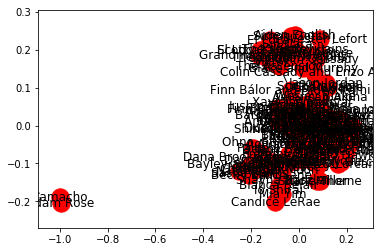

In [26]:
#draws map

G = networkx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(team_dyads, colors='r', weight=20)
G.add_edges_from(had_a_match_pairs, colors='b', weight=20)
G

networkx.draw_networkx(G, with_labels = True)

c:\python37\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


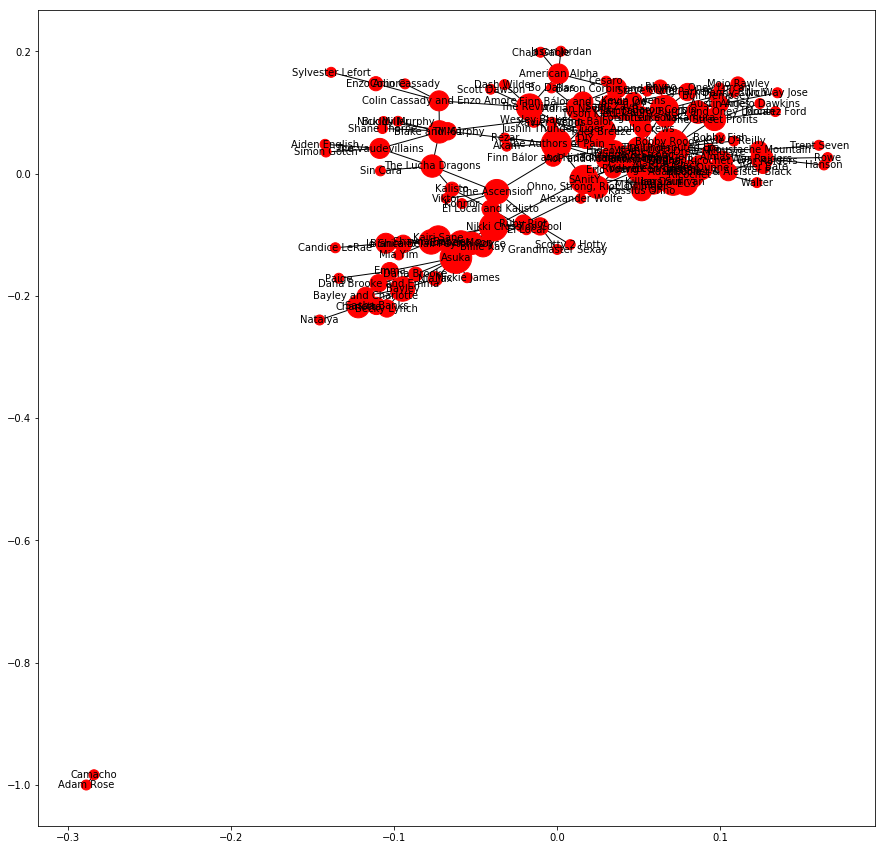

In [27]:
#redoes map, larger output, better layout, etc.

plt.figure(figsize=(15,15))
pos = networkx.spring_layout(G)
deg = networkx.degree(G)
deg = [deg[k]*100 for k in G.nodes]
networkx.draw_networkx(G,pos=pos, with_labels=True,
                node_size=deg,font_size=10)

c:\python37\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


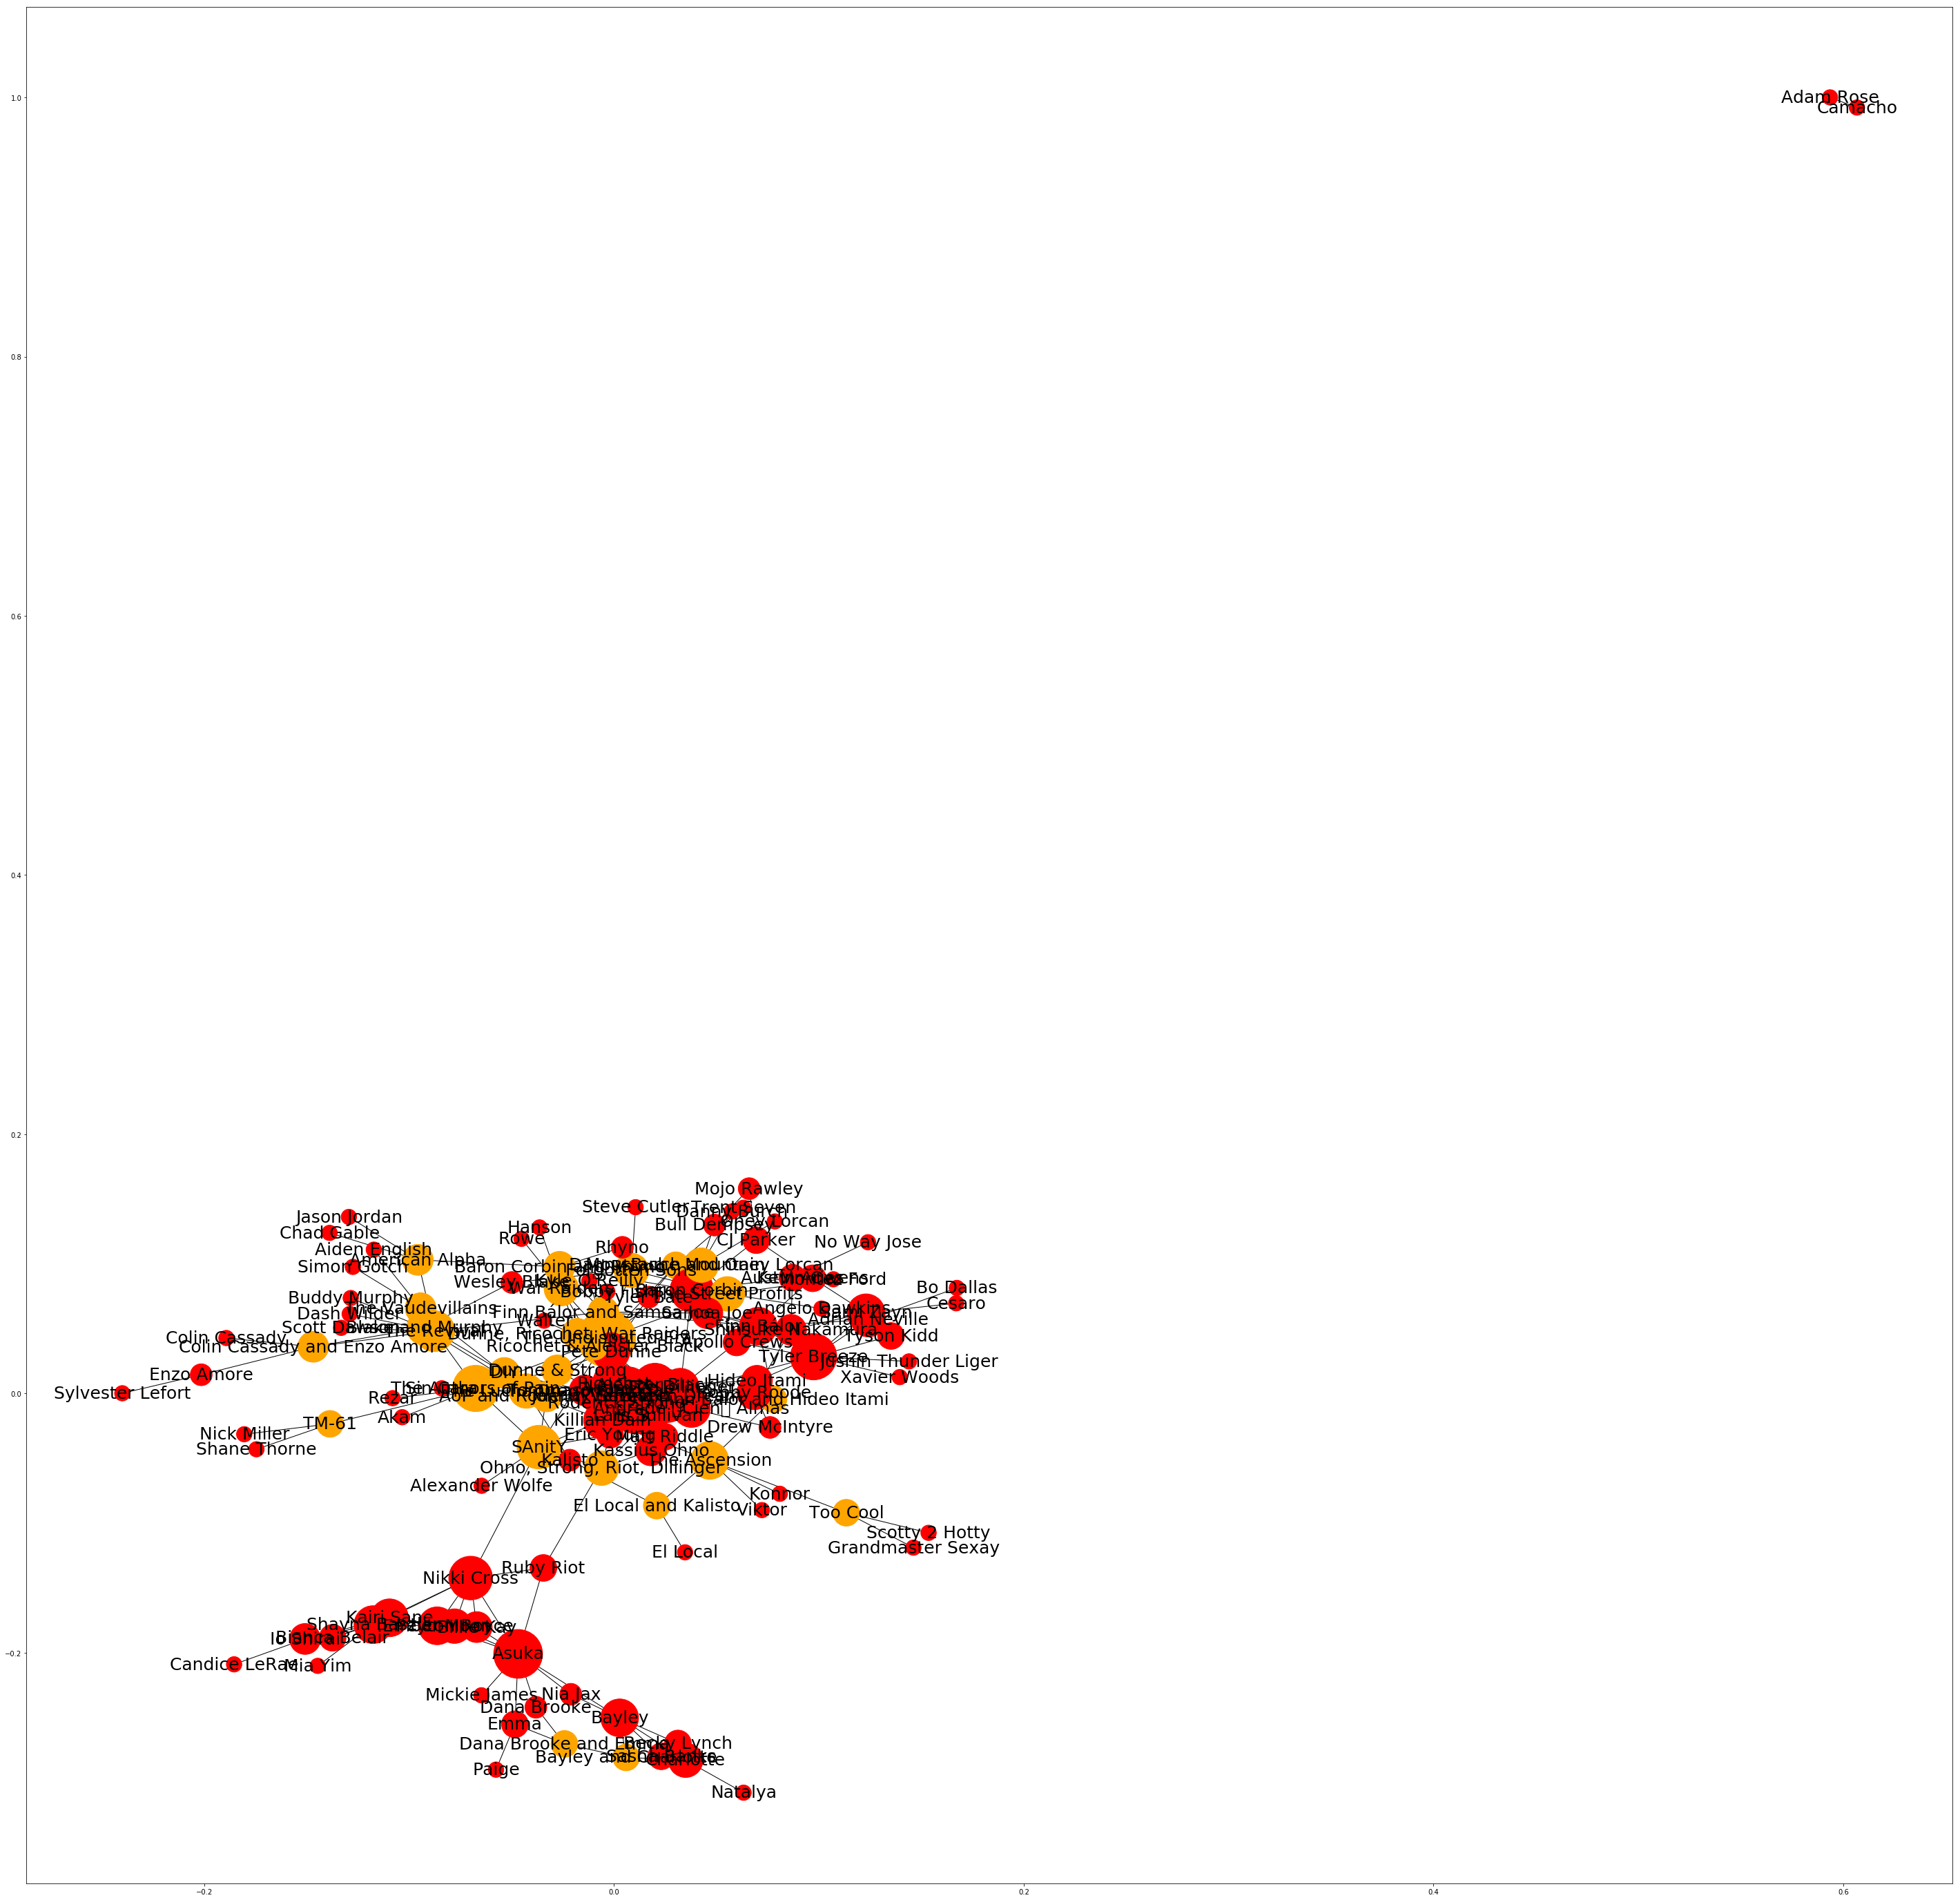

In [28]:
#recolors such that tag team nodes are a different color than wrestler nodes

plt.figure(figsize=(50,50))
colors = []
for n in G.nodes:
    if n in teams:
        colors.append('orange')
    else:
        colors.append('red')
pos = networkx.spring_layout(G)
deg = networkx.degree(G)
deg = [deg[k]*500 for k in G.nodes]
networkx.draw_networkx(G,pos=pos, with_labels=True, node_color=colors,
                node_size=deg,font_size=25)

In [29]:
#there's only one match that's not linked to the rest of the network, so for interpretability I am removing that match

disconnected_nodes = ['Adam Rose', 'Camacho']
for item in disconnected_nodes:
    G.remove_node(item)

In [30]:
G.remove_nodes_from(networkx.isolates(G))

c:\python37\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


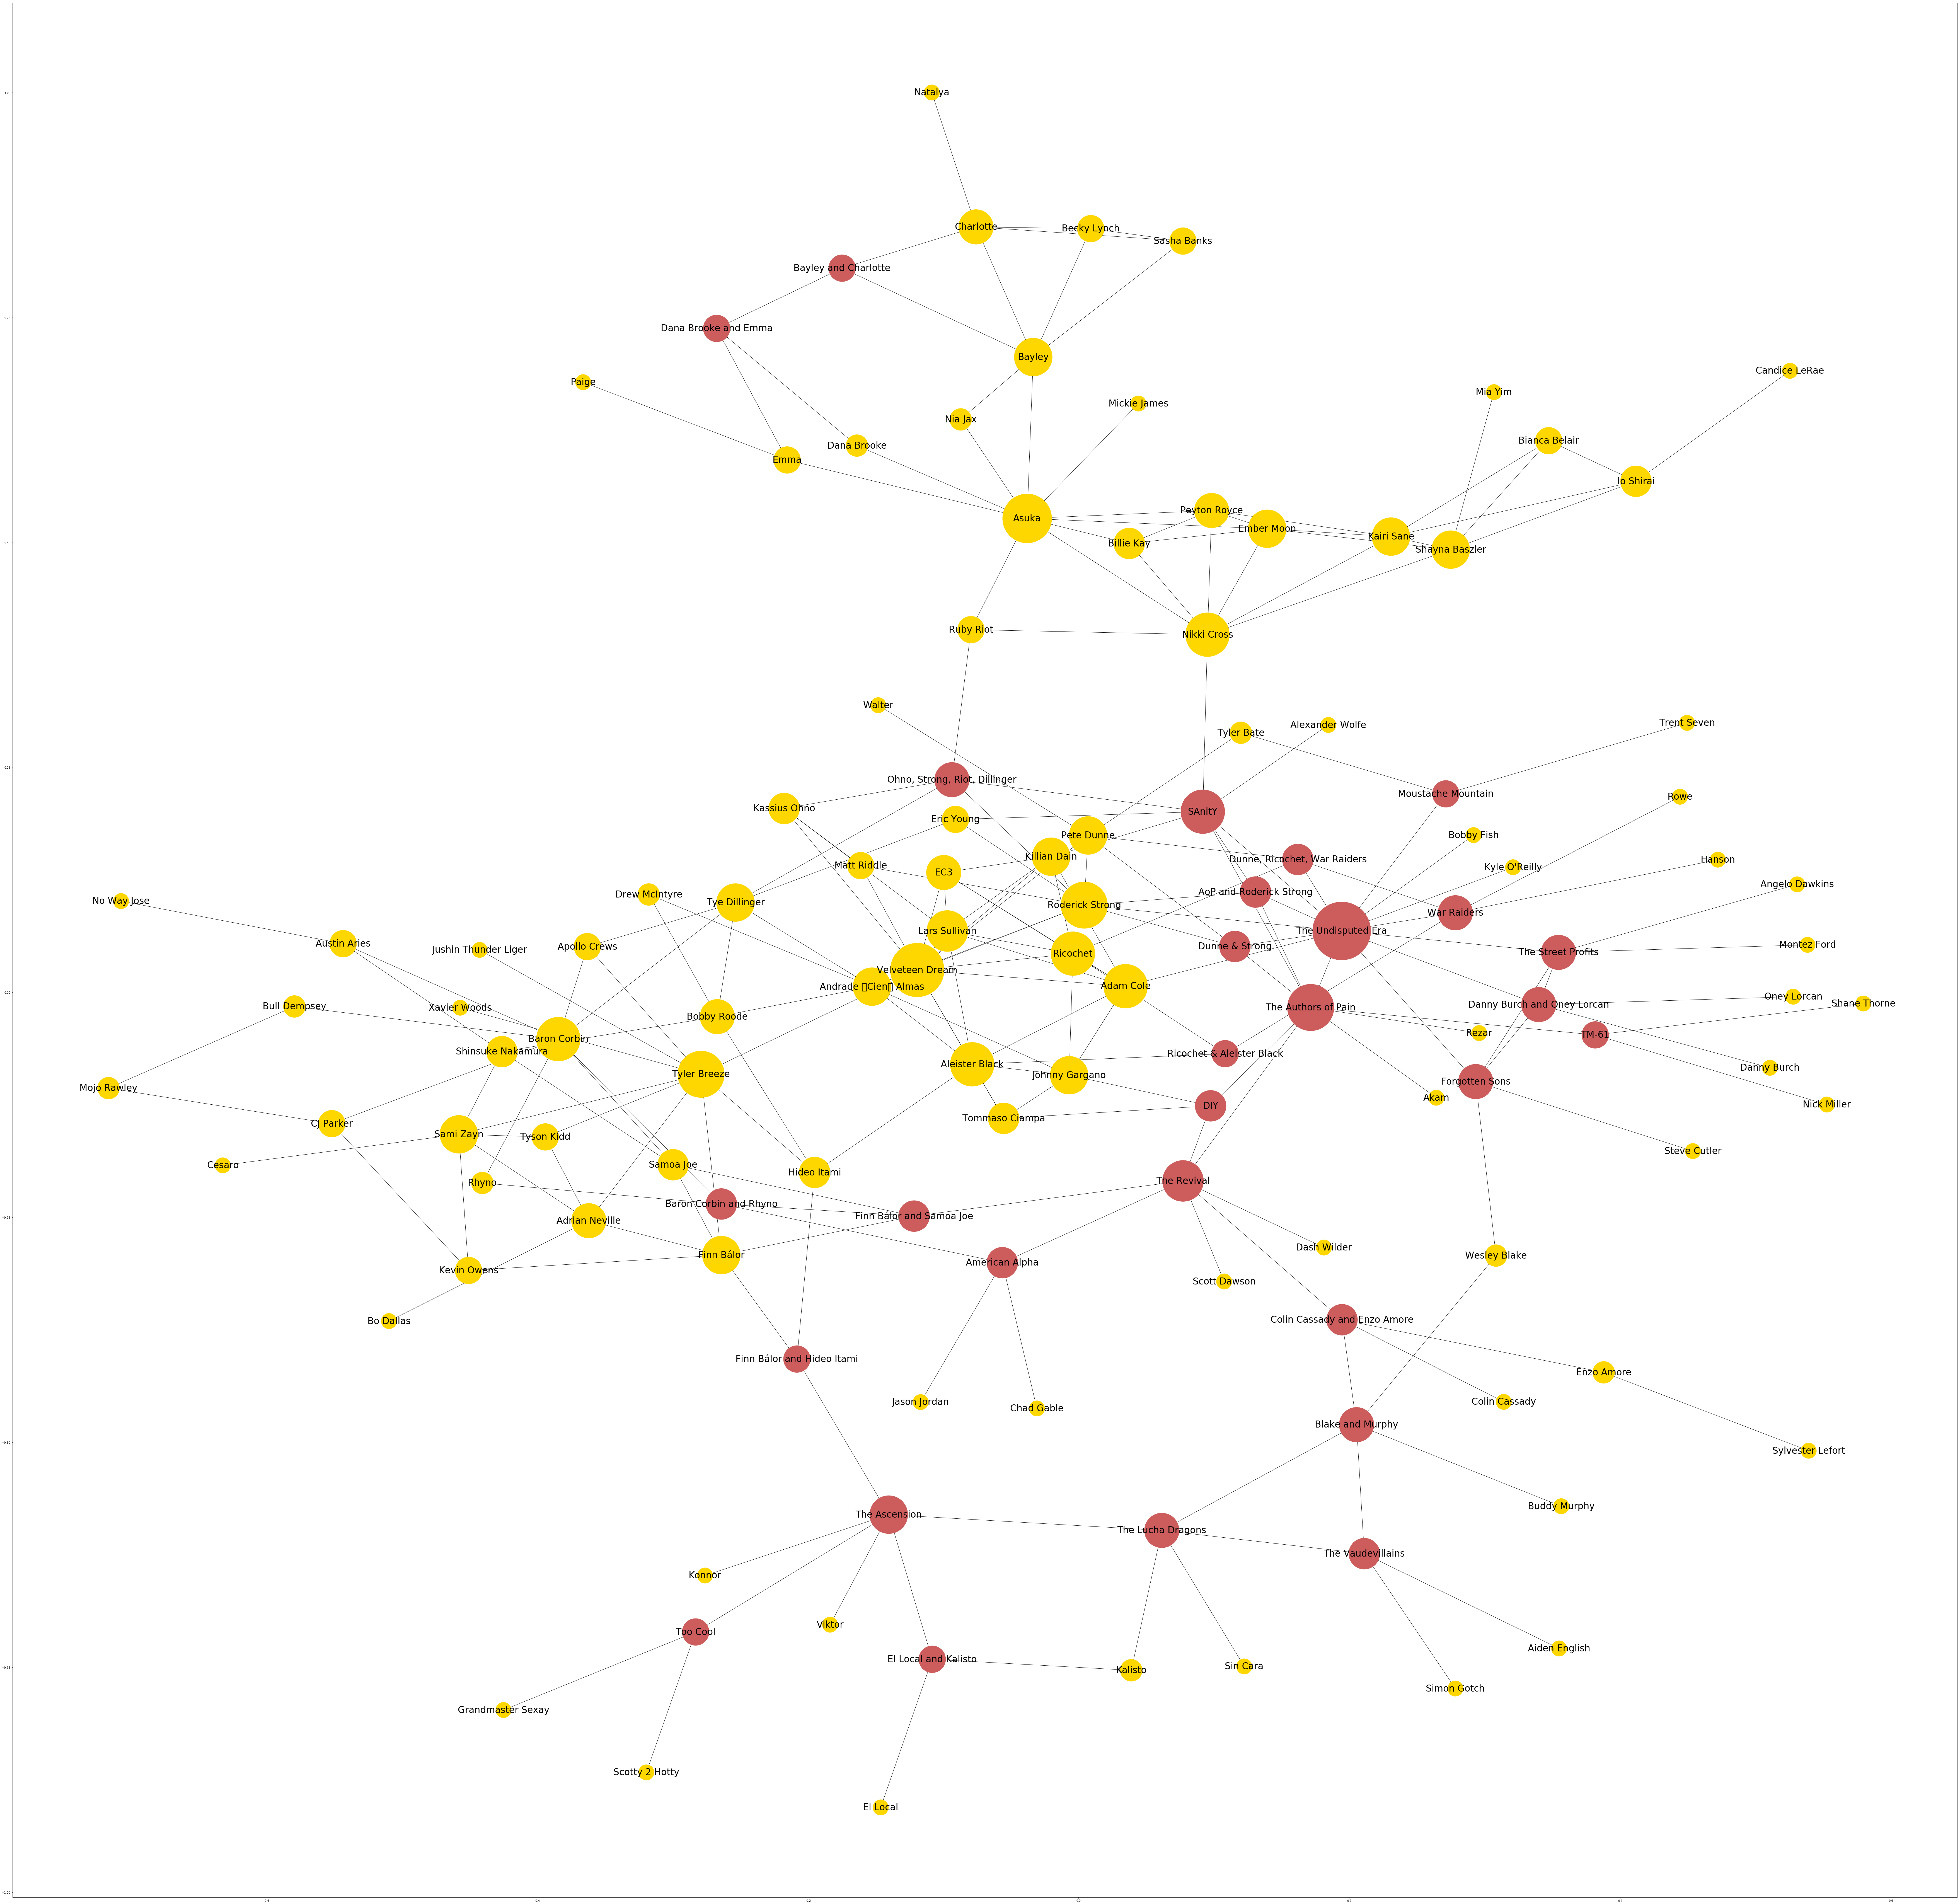

In [31]:
#recolor & redraw, and saves the figure

fig = plt.figure(figsize=(125,125), facecolor='none')
colors = []
shapes = []
size = []
for n in G.nodes:
    #size.append(eig_c[n]*250000)
    if n in teams:
        colors.append('indianred')
        shapes.append('d')
    else:
        colors.append('gold')
        shapes.append('d')
pos = networkx.kamada_kawai_layout(G)
deg = networkx.degree(G)
deg = [deg[k]*3100 for k in G.nodes]
networkx.draw_networkx(G,pos=pos, with_labels=True, node_color=colors, edge_color='black',
                node_size=deg,font_size=33, facecolor='none')
plt.savefig('yourname.png')

Some centrality measures.

In [21]:
deg = networkx.degree_centrality(G)

s = pd.Series(deg, name='DateValue')

s.sort_values(ascending=False)

The Undisputed Era      0.112903
Velveteen Dream         0.096774
Asuka                   0.080645
Roderick Strong         0.072581
Tyler Breeze            0.072581
The Authors of Pain     0.072581
Aleister Black          0.064516
Baron Corbin            0.064516
Ricochet                0.064516
Adam Cole               0.064516
SAnitY                  0.064516
Nikki Cross             0.064516
The Revival             0.056452
Lars Sullivan           0.056452
Ember Moon              0.048387
Johnny Gargano          0.048387
Killian Dain            0.048387
Tye Dillinger           0.048387
Finn Bálor              0.048387
The Ascension           0.048387
Bayley                  0.048387
Andrade Cien Almas    0.048387
Sami Zayn               0.048387
Kairi Sane              0.048387
Shayna Baszler          0.048387
Pete Dunne              0.048387
War Raiders             0.040323
Adrian Neville          0.040323
Forgotten Sons          0.040323
Blake and Murphy        0.040323
          

In [22]:
eig_c = networkx.eigenvector_centrality_numpy(G)
toy_adj = networkx.adjacency_matrix(G)
print(eig_c)
val,vec = np.linalg.eig(toy_adj.toarray())
print(val)
vec[:,0]

{'Colin Cassady and Enzo Amore': 0.006118516858324099, 'Ruby Riot': 0.023476836210180242, 'Cesaro': 0.004054781340099176, 'Matt Riddle': 0.11405687275636468, 'Dana Brooke and Emma': 0.0012646097285216706, 'Bayley': 0.0046139997717944995, 'Eric Young': 0.06329514747662661, 'The Vaudevillains': 0.0005817615458833405, 'Charlotte': 0.001245548084120758, 'Sami Zayn': 0.026215353105219448, 'Bianca Belair': 0.00559745395862762, 'Becky Lynch': 0.0010721377390171323, 'The Revival': 0.03501125446573501, 'Shinsuke Nakamura': 0.013020301633929691, 'The Ascension': 0.002570127690302265, 'Shayna Baszler': 0.01419025330128765, 'Roderick Strong': 0.20939692161043286, 'Rhyno': 0.0036663881197618368, 'Bull Dempsey': 0.002882605409823727, 'Moustache Mountain': 0.040619198767159026, 'Pete Dunne': 0.13419339565169244, 'Finn Bálor and Samoa Joe': 0.011977613791586504, 'Peyton Royce': 0.01781818858700648, 'Kevin Owens': 0.00868435145213778, 'The Authors of Pain': 0.11646625199093177, 'El Local and Kalisto': 

  9.82656605e-18+0.00000000e+00j]


array([6.11851686e-03+0.j, 2.34768362e-02+0.j, 4.05478134e-03+0.j,
       1.14056873e-01+0.j, 1.26460973e-03+0.j, 4.61399977e-03+0.j,
       6.32951475e-02+0.j, 5.81761546e-04+0.j, 1.24554808e-03+0.j,
       2.62153531e-02+0.j, 5.59745396e-03+0.j, 1.07213774e-03+0.j,
       3.50112545e-02+0.j, 1.30203016e-02+0.j, 2.57012769e-03+0.j,
       1.41902533e-02+0.j, 2.09396922e-01+0.j, 3.66638812e-03+0.j,
       2.88260541e-03+0.j, 4.06191988e-02+0.j, 1.34193396e-01+0.j,
       1.19776138e-02+0.j, 1.78181886e-02+0.j, 8.68435145e-03+0.j,
       1.16466252e-01+0.j, 4.41383947e-04+0.j, 4.13943214e-03+0.j,
       2.45421629e-01+0.j, 1.62830515e-02+0.j, 1.19573628e-01+0.j,
       1.37694951e-01+0.j, 1.97190184e-02+0.j, 9.50461365e-04+0.j,
       4.17503023e-04+0.j, 1.89192982e-02+0.j, 4.25674794e-02+0.j,
       4.22583150e-03+0.j, 2.70386152e-02+0.j, 1.06623205e-01+0.j,
       3.35184746e-01+0.j, 2.07559621e-02+0.j, 6.23173508e-02+0.j,
       2.57057000e-02+0.j, 5.51860971e-02+0.j, 2.19483499e-03+

In [23]:
s = pd.Series(eig_c, name='DateValue')

s.sort_values(ascending=False)

Velveteen Dream                  0.390319
Adam Cole                        0.335185
Ricochet                         0.298789
Lars Sullivan                    0.297638
Killian Dain                     0.264792
Aleister Black                   0.252117
EC3                              0.245422
The Undisputed Era               0.229294
Roderick Strong                  0.209397
Johnny Gargano                   0.188697
SAnitY                           0.144604
Tommaso Ciampa                   0.140042
Kassius Ohno                     0.137695
Pete Dunne                       0.134193
Andrade Cien Almas             0.119574
The Authors of Pain              0.116466
Matt Riddle                      0.114057
Dunne, Ricochet, War Raiders     0.113466
AoP and Roderick Strong          0.108233
Dunne & Strong                   0.106623
Ricochet & Aleister Black        0.096240
Tyler Breeze                     0.094203
Ohno, Strong, Riot, Dillinger    0.088224
DIY                              0

In [24]:
eig_c["El Local"]

6.82697419387891e-05

In [25]:
betw = networkx.betweenness_centrality(G)
s = pd.Series(betw, name='DateValue')

s.sort_values(ascending=False)

SAnitY                           0.265257
The Undisputed Era               0.254876
Nikki Cross                      0.225610
The Authors of Pain              0.192925
The Revival                      0.191692
Asuka                            0.182308
The Ascension                    0.132566
Tyler Breeze                     0.123085
Tye Dillinger                    0.118652
Ohno, Strong, Riot, Dillinger    0.118458
Velveteen Dream                  0.116981
Finn Bálor and Hideo Itami       0.114477
Blake and Murphy                 0.109692
Colin Cassady and Enzo Amore     0.097436
Baron Corbin                     0.089788
Ruby Riot                        0.083093
Roderick Strong                  0.080851
Hideo Itami                      0.080824
Forgotten Sons                   0.079923
Bayley                           0.076886
Finn Bálor                       0.074998
The Lucha Dragons                0.073140
Wesley Blake                     0.058176
Finn Bálor and Samoa Joe         0